## Курсовая работа по дисциплине "Машинное обучение" на тему "Использование моделей машинного обучения, построенных на основе регрессий"

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
import itertools
import warnings
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_style('darkgrid')  # Настримваем "красивое" отображение графиков
sns.set_palette('flare')
warnings.simplefilter("ignore")  # Отключаем предупреждения

<span style="color:mediumblue">
Предупреждения выключаю, чтобы не вылезали красные некрасивые уведомления от sklearn о выходе из цикла по превышению итераций.
</span>

## Выбор датасета

<span style="color:mediumblue">
Поскольку тема поставлена довольно широко, я решил выбрать тематику датасета, близкую себе по душе. Выбор остановился на компьютерном железе.
</span>

https://www.kaggle.com/datasets/docyoda/computer-parts-and-accessories

<span style="color:mediumblue">
Нашел на Kaggle дюжину датасетов с данными по различным компьютерным компонентам от одного автора и решил выбрать из них наиболее подходящий для задачи регрессии. 
</span>

<span style="color:mediumblue">
Я планирую попробывать предсказывать цену компонента, основываясь на других известных данных о нем.
</span>

In [28]:
max_name = max([len(x) for x in os.listdir('./data_curs')])  # Находим макс. длинну названия для аккуратного отображения

for dataset in os.scandir('./data_curs'):  # Сканируем датасеты в директории
    df = pd.read_json(dataset.path)
    print(f'Имя: {dataset.name.ljust(max_name, " ")} размер: {str(df.shape).ljust(9, " ")} непустые в целевой: '
          f'{str(df["price"].dropna().size).ljust(4, " ")} доля непустых в целевой: '
          f'{df["price"].dropna().size/df.shape[0]}')

Имя: case-fan.json            размер: (1492, 8) непустые в целевой: 862  доля непустых в целевой: 0.5777479892761395
Имя: cpu-cooler.json          размер: (1111, 6) непустые в целевой: 491  доля непустых в целевой: 0.44194419441944194
Имя: cpu.json                 размер: (1213, 8) непустые в целевой: 547  доля непустых в целевой: 0.45094806265457543
Имя: external-hard-drive.json размер: (319, 7)  непустые в целевой: 152  доля непустых в целевой: 0.47648902821316613
Имя: headphones.json          размер: (2288, 8) непустые в целевой: 804  доля непустых в целевой: 0.3513986013986014
Имя: internal-hard-drive.json размер: (3788, 8) непустые в целевой: 1743 доля непустых в целевой: 0.4601372756071806
Имя: memory.json              размер: (7151, 8) непустые в целевой: 2338 доля непустых в целевой: 0.32694728010068524
Имя: monitor.json             размер: (2768, 8) непустые в целевой: 1128 доля непустых в целевой: 0.407514450867052
Имя: mouse.json               размер: (1948, 7) непустые в це

<span style="color:mediumblue">
Наиболее важным параметром для отбора я счел кол-во непустых значений целевой переменной (которой предполагается цена), т.к. даже, допустим, заполнение средним значением, не дало бы лучших результатов из-за неуникальности сэмплов (sample).
</span>

<span style="color:mediumblue">
Вследствие этого выбор пал на датасет об <i>оперативной памяти</i> под названием <i>memory.json</i>. В этом датасете содержится 8 колонок (потенциальных фичей (feature)), он самый объемный из предложенных (7151 строка), да и значений цены там также больше всего (2338 строк).
</span>

## Первичный анализ

In [32]:
mem = pd.read_json(r'./data_curs/memory.json')  # Считываем датасет
mem

,speed,type,modules,price_/_gb,color,cas_latency,name,price
0,DDR4-3000,288-pin DIMM,2 x 8GB,$5.555,Black / Yellow,15.0,Corsair Vengeance LPX 16 GB,$88.88
1,DDR4-3200,288-pin DIMM,2 x 8GB,$5.630,Black / Yellow,16.0,Corsair Vengeance LPX 16 GB,$90.08
2,DDR4-3200,288-pin DIMM,2 x 8GB,$6.406,Black,16.0,G.Skill Trident Z RGB 16 GB,$102.49
3,DDR4-3200,288-pin DIMM,2 x 8GB,$6.512,Black,16.0,Corsair Vengeance RGB Pro 16 GB,$104.19
4,DDR4-3200,288-pin DIMM,2 x 16GB,$5.665,Black,16.0,Corsair Vengeance RGB Pro 32 GB,$181.29
...,...,...,...,...,...,...,...,...
7146,DDR3-1600,240-pin DIMM,3 x 4GB,None,Black,10.0,Mushkin Blackline 12 GB,None
7147,DDR3-1600,240-pin DIMM,2 x 4GB,None,Black,10.0,Mushkin Blackline 8 GB,None
7148,DDR3-1866,240-pin DIMM,2 x 8GB,None,Red,9.0,Mushkin Redline 16 GB,None
7149,DDR3-1866,240-pin DIMM,4 x 8GB,None,Red,9.0,Mushkin Redline 32 GB,None


In [5]:
mem.info()  # Основная информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7151 entries, 0 to 7150
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   speed        7151 non-null   object 
 1   type         7151 non-null   object 
 2   modules      7151 non-null   object 
 3   price_/_gb   2338 non-null   object 
 4   color        6889 non-null   object 
 5   cas_latency  7147 non-null   float64
 6   name         7151 non-null   object 
 7   price        2338 non-null   object 
dtypes: float64(1), object(7)
memory usage: 447.1+ KB


In [6]:
df.isna().sum()  # Кол-во null в каждом столбце

chipset           0
memory            0
core_clock      121
boost_clock    2253
interface         0
color           284
name              0
price          3037
dtype: int64

<span style="color:mediumblue">
После вывода описательной информации можно заметить, что меньше всего значений (из потенциально полезных колонок), к сожалению, в столбце price, а остальные столбцы практически полностью заполнены.
</span>

In [7]:
df.describe()  # Краткая сводка по числовым характеристикам

,chipset,memory,core_clock,boost_clock,interface,color,name,price
count,4175,4175,4054,1922,4175,3891,4175,1138
unique,275,22,333,253,5,54,3123,1120
top,GeForce GTX 1080,2 GB,1000 MHz,1683 MHz,PCIe x16,Black,Gigabyte WINDFORCE,$717.19
freq,80,948,189,70,4133,855,36,2


## Предобработка

In [33]:
mem.head()

,speed,type,modules,price_/_gb,color,cas_latency,name,price
0,DDR4-3000,288-pin DIMM,2 x 8GB,$5.555,Black / Yellow,15.0,Corsair Vengeance LPX 16 GB,$88.88
1,DDR4-3200,288-pin DIMM,2 x 8GB,$5.630,Black / Yellow,16.0,Corsair Vengeance LPX 16 GB,$90.08
2,DDR4-3200,288-pin DIMM,2 x 8GB,$6.406,Black,16.0,G.Skill Trident Z RGB 16 GB,$102.49
3,DDR4-3200,288-pin DIMM,2 x 8GB,$6.512,Black,16.0,Corsair Vengeance RGB Pro 16 GB,$104.19
4,DDR4-3200,288-pin DIMM,2 x 16GB,$5.665,Black,16.0,Corsair Vengeance RGB Pro 32 GB,$181.29


<span style="color:mediumblue">
Вкратце о столбцах исходного датасета (в меру моего понимания):<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>speed</i> - Скорость памяти (MHz)<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>type</i> - Тип памяти<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>modules</i> - Кол-во плашек в комплекте и объем каждой (GB, MB)<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>price_/_gb</i> - Цена за гигабайт (USD)<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>color</i> - Цвет памяти<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>cas_latency</i> - Тайминги ОЗУ (ns / наносекунды)<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>name</i> - Название<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>price</i> - Цена (USD)
</span>

In [8]:
mem['price'] = mem['price'].str.replace('$', '', regex=False).str.strip().astype(float)  # Преобразуем столбец price

mem['total_gb'] = mem['modules'].str.replace('x', '*').apply(lambda x: eval(re.sub('GB|MB', '', x)))  
# Получаем total_gb из modules
mem['total_gb'] *= mem['modules'].apply(lambda x: 1 if re.search('GB', x) else 1/1024)  # Учитываем случаи с MB

mem['amount'] = mem['modules'].apply(lambda x: int(x.split(' x ')[0]))  # Получаем amount из modules

mem['kind'] = mem['speed'].apply(lambda x: x.split('-')[0])  # Получаем kind из speed

mem['speed'] = mem['speed'].apply(lambda x: int(x.split('-')[1]))  # Преобразоваываем speed

mem.head()

,speed,type,modules,price_/_gb,color,cas_latency,name,price,total_gb,amount,kind
0,3000,288-pin DIMM,2 x 8GB,$5.555,Black / Yellow,15.0,Corsair Vengeance LPX 16 GB,88.88,16.0,2,DDR4
1,3200,288-pin DIMM,2 x 8GB,$5.630,Black / Yellow,16.0,Corsair Vengeance LPX 16 GB,90.08,16.0,2,DDR4
2,3200,288-pin DIMM,2 x 8GB,$6.406,Black,16.0,G.Skill Trident Z RGB 16 GB,102.49,16.0,2,DDR4
3,3200,288-pin DIMM,2 x 8GB,$6.512,Black,16.0,Corsair Vengeance RGB Pro 16 GB,104.19,16.0,2,DDR4
4,3200,288-pin DIMM,2 x 16GB,$5.665,Black,16.0,Corsair Vengeance RGB Pro 32 GB,181.29,32.0,2,DDR4


<span style="color:mediumblue">
Я привел типы нескольких столбцов к числовым. Сделал столбцы <i>total_gb</i> и <i>amount</i> из столбца <i>modules</i>. И так же сделал столбцы <i>kind</i> и <i>speed</i> (новый) из столбца <i>speed</i>.
</span>

In [9]:
df = mem[['name', 'kind', 'type', 'amount', 'total_gb', 'speed', 'cas_latency', 'price']]
df.head()

,name,kind,type,amount,total_gb,speed,cas_latency,price
0,Corsair Vengeance LPX 16 GB,DDR4,288-pin DIMM,2,16.0,3000,15.0,88.88
1,Corsair Vengeance LPX 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,90.08
2,G.Skill Trident Z RGB 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,102.49
3,Corsair Vengeance RGB Pro 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,104.19
4,Corsair Vengeance RGB Pro 32 GB,DDR4,288-pin DIMM,2,32.0,3200,16.0,181.29


<span style="color:mediumblue">
Описание итогового датасета:<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>name</i> - Название<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>kind</i> - Вид памяти<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>type</i> - Тим памяти<br>    
&nbsp;&nbsp;&nbsp;&nbsp; <i>amount</i> - Кол-во плашек в комплекте<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>total_gb</i> - Всего гигабайт в комплекте<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>speed</i> - Скорость памяти (MHz)<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>cas_latency</i> - Тайминги ОЗУ (ns / наносекунды)<br>
&nbsp;&nbsp;&nbsp;&nbsp; <i>price</i> - Цена (USD)
</span>

In [10]:
df.dtypes  # Получившиеся типы

name            object
kind            object
type            object
amount           int64
total_gb       float64
speed            int64
cas_latency    float64
price          float64
dtype: object

In [11]:
df.describe()  # Краткая сводка по числовым характеристикам

,amount,total_gb,speed,cas_latency,price
count,7151.000000,7151.000000,7151.000000,7147.000000,2338.000000
mean,2.391693,17.750315,2233.699622,12.331608,180.463221
std,1.376520,19.088621,786.283857,3.704788,225.044685
min,1.000000,0.500000,333.000000,3.000000,7.990000
25%,2.000000,8.000000,1600.000000,9.000000,55.190000
50%,2.000000,16.000000,2133.000000,11.000000,103.735000
75%,3.000000,16.000000,2800.000000,16.000000,210.912500
max,8.000000,256.000000,5000.000000,22.000000,2824.550000


<span style="color:mediumblue">
Далее создаю несколько групп графиков для визуального анализа данных.
</span>

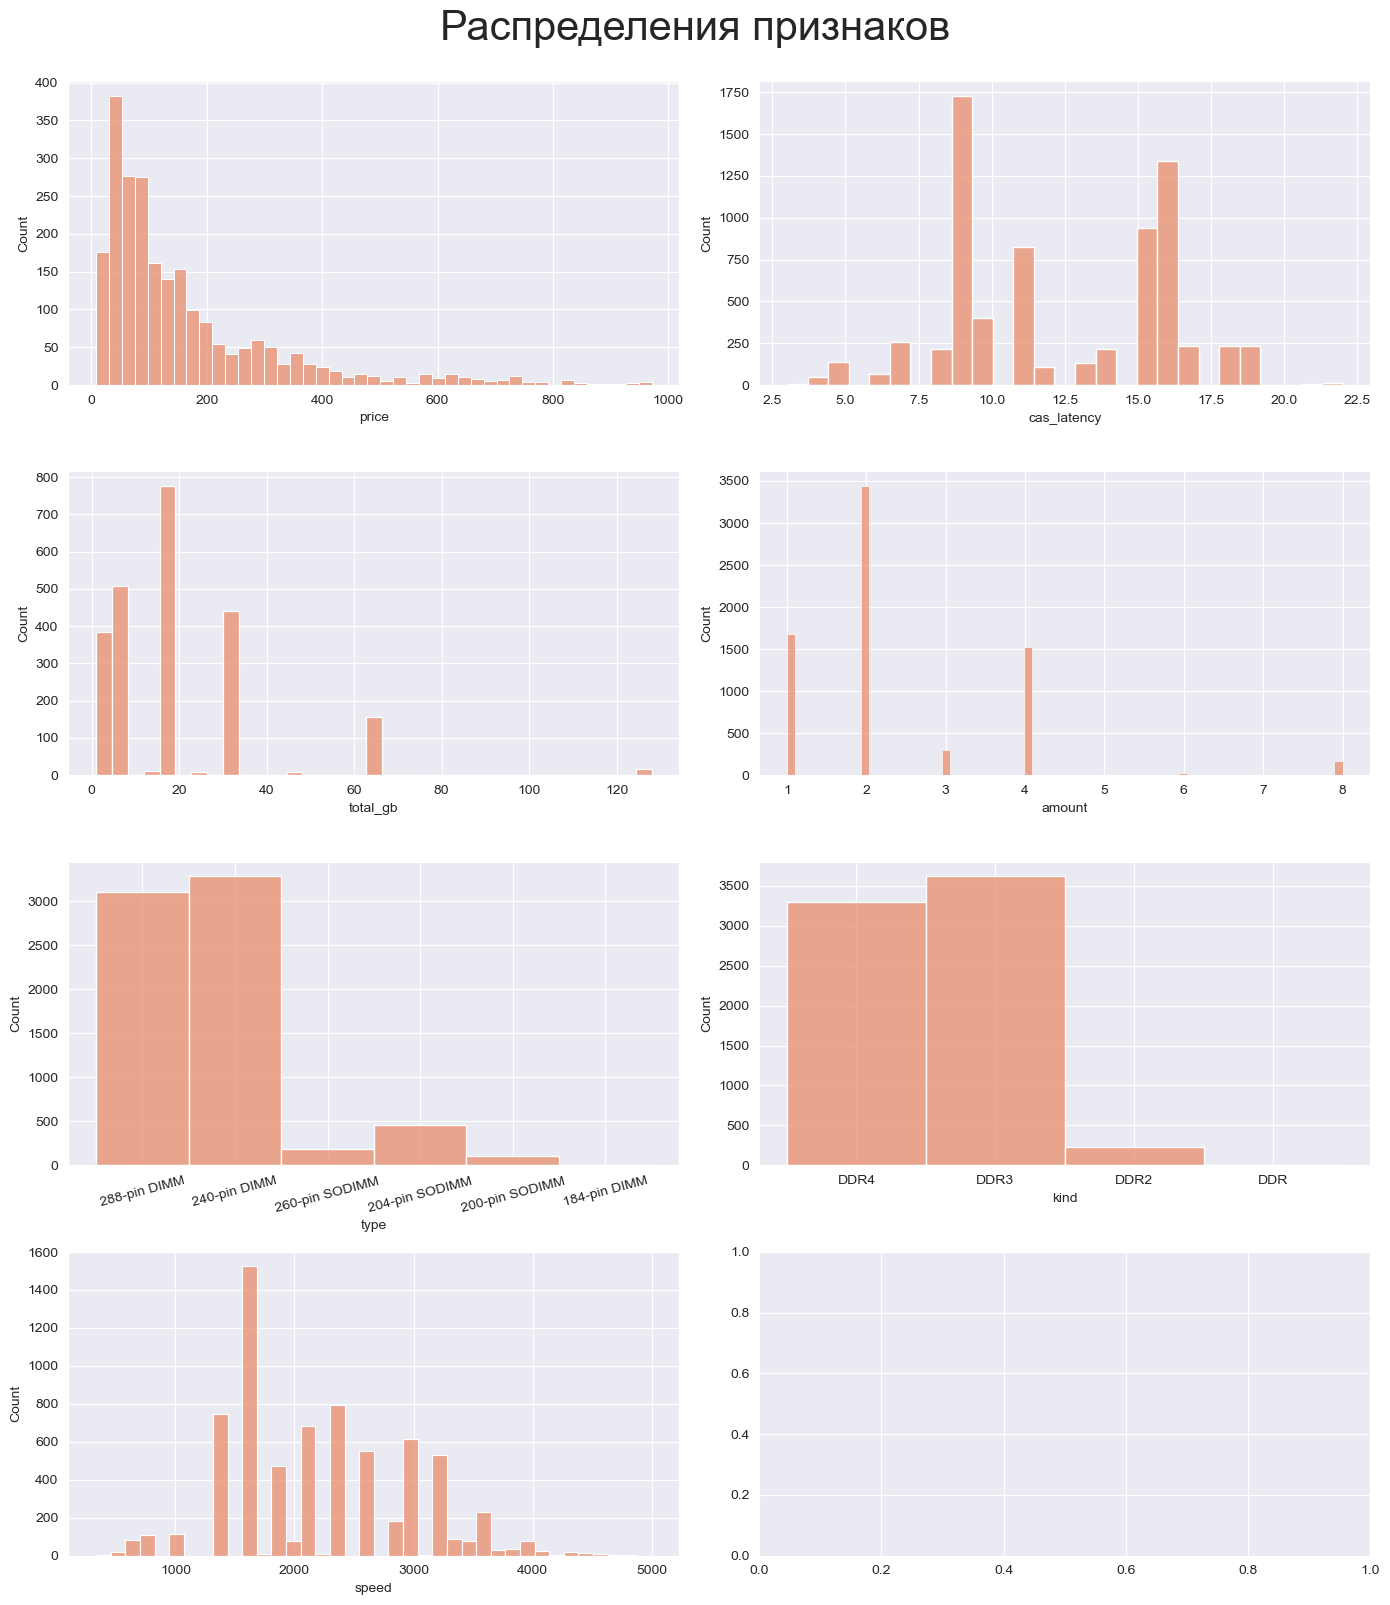

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))  # Определение фигуры

sns.histplot(data=df[df.price<=1000], x='price', ax=ax[0, 0])  # Отрисовки графиков
sns.histplot(data=df, x='cas_latency', ax=ax[0, 1])
sns.histplot(data=df[df.price<=1000], x='total_gb', ax=ax[1, 0]) 
# Некоторые значения немного подрезаю, чтобы опрятнее смотрелось на графике
sns.histplot(data=df, x='amount', ax=ax[1, 1])
sns.histplot(data=df, x='type', ax=ax[2, 0]).set_xticklabels(df.type.unique(), rotation=15)
sns.histplot(data=df, x='kind', ax=ax[2, 1])
sns.histplot(data=df, x='speed', ax=ax[3, 0])

plt.suptitle('Распределения признаков', fontsize=30, y=1)  # Вывод заголовка
plt.tight_layout()

<span style="color:mediumblue">
Судя по графикам выше можно сказать, что:<br>
    1. Больше всего комплектов с ценой в районе 50 USD<br>
    2. Самые частовстречающиеся тайминги - это 9 и 16<br>
    3. Чаще всего встречаются комплекты на 16 гб, и чуть реже на 8 и 32 гб<br>
    4. Самое частое кол-во плашек в наборе - 2
    5. 288 и 240 -pin dim сильно лидируют по количеству среди остальных типов
    6. DDR3 встречается чуть чаще, чем DDR4 в то время, как DDR2 очень редка по сравнению с ними
    7. Больше всего плашек со скоростью 1600+-100 MHz, но, в остальном, распределение выглядит нормальным
</span>

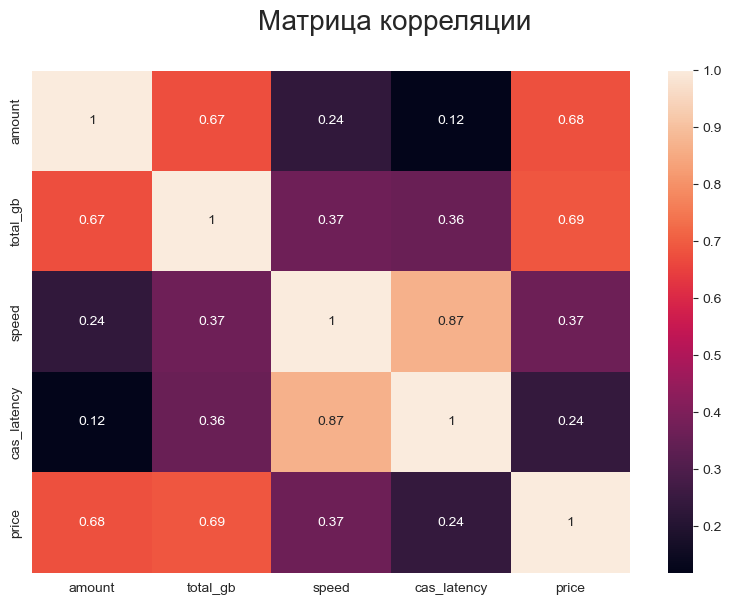

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(df.corr(), annot=True)  # Тепловая карта

plt.suptitle('Матрица корреляции', fontsize=20, y=1)
plt.tight_layout()

<span style="color:mediumblue">
По матрице корреляции можем сделать вывод, что, к сожалению, датасет не обладает большим количеством хорошо-коррелированных фичей. Но попытаться построить модели регрессии все же можно.
</span>

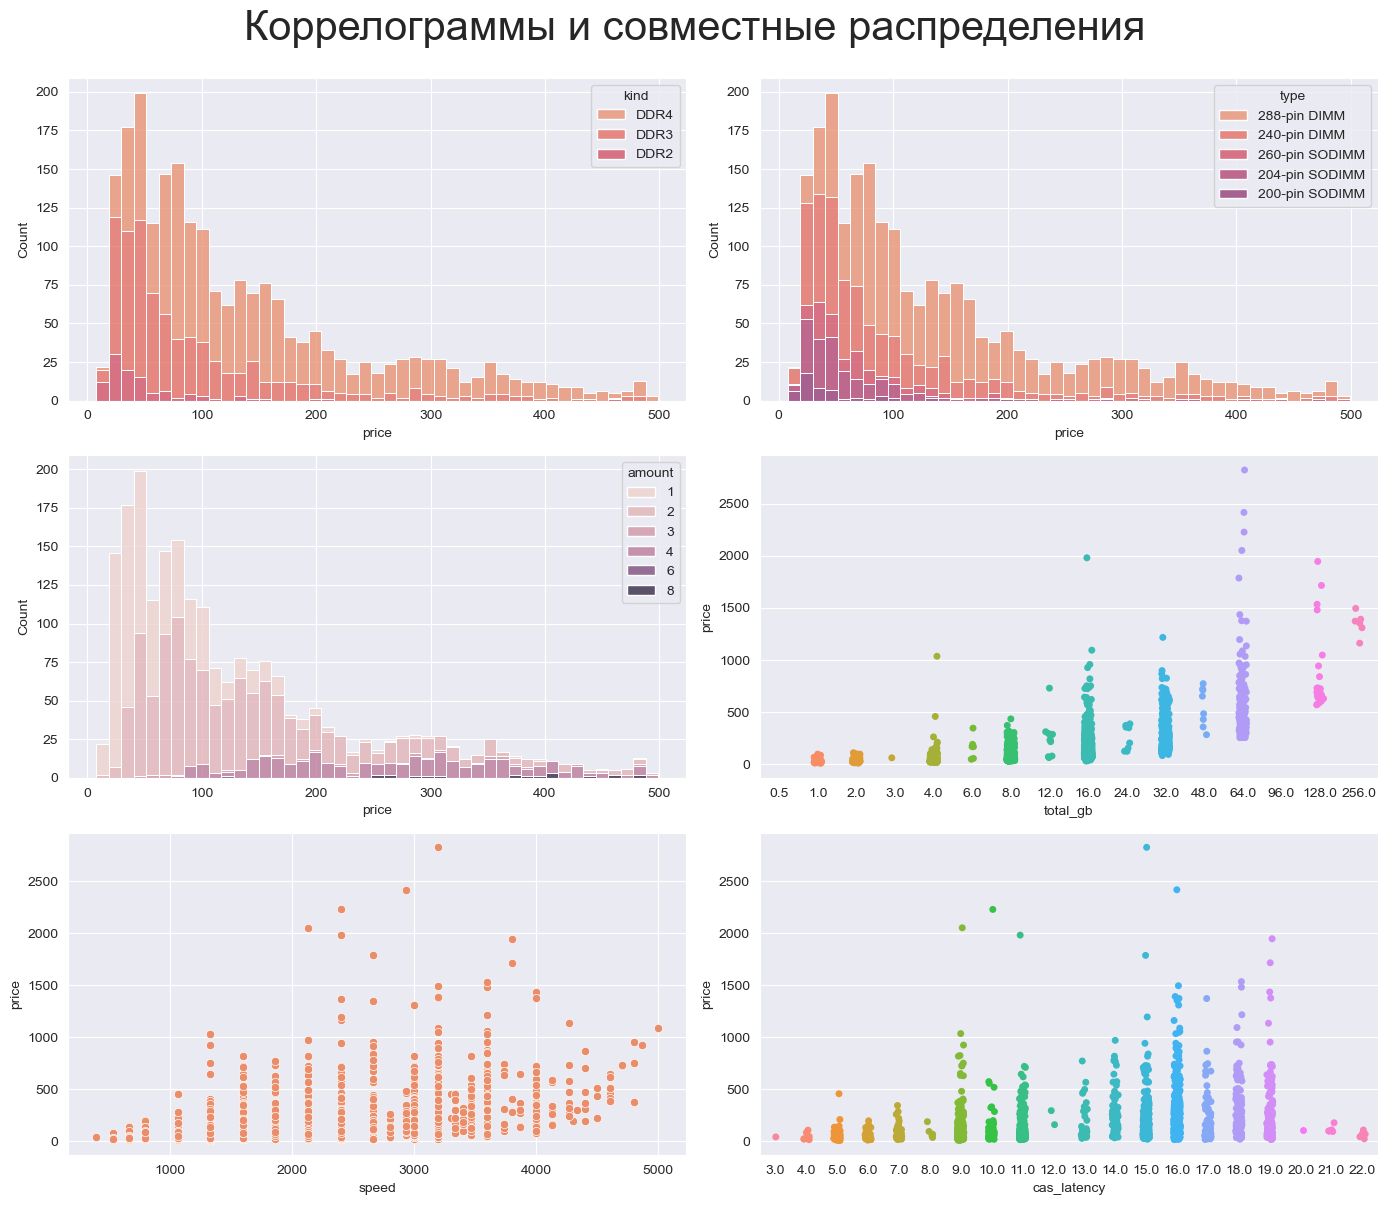

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

sns.histplot(data=df[df.price<=500], x='price', hue='kind', multiple='stack', bins=45, ax=ax[0, 0])
#sns.violinplot(data=df[df.price<=300], x='kind', y='price', ax=ax[0, 0])
sns.histplot(data=df[df.price<=500], x='price', hue='type', multiple='stack', bins=45, ax=ax[0, 1])
#sns.violinplot(data=df[df.price<=300], x='type', y='price', ax=ax[0, 1])
sns.histplot(data=df[df['price']<=500], x='price', hue='amount', multiple='stack', bins=45, ax=ax[1, 0])
#sns.violinplot(data=df[df.price<=500], x='amount', y='price', ax=ax[1, 0])
sns.stripplot(data=df, x='total_gb', y='price', ax=ax[1, 1])
sns.scatterplot(data=df, x='speed', y='price', ax=ax[2, 0])
sns.stripplot(data=df, x='cas_latency', y='price', ax=ax[2, 1])

plt.suptitle('Коррелограммы и совместные распределения', fontsize=30, y=1)
plt.tight_layout()

<span style="color:mediumblue">
Линейных связей не наблюдается, зато присутсвуют схожие тренды для распределений.
</span>

## Очистка данных

In [16]:
df.shape, df.dropna(subset='price').shape, df2.shape

((7151, 8), (2338, 8), (2335, 8))

<span style="color:mediumblue">
После сравнения потерь от удаления nan только в столбце price и по всему датасету я принял решение удалить nan во всех столбцах, т.к. разница получается всего в 3 строки, зато так мы получаем абсолютно чистые данные в смысле пропусков.
</span>

In [15]:
df2 = df.dropna()  # Удаление строк, содержащих nan из датасета
df2

,name,kind,type,amount,total_gb,speed,cas_latency,price
0,Corsair Vengeance LPX 16 GB,DDR4,288-pin DIMM,2,16.0,3000,15.0,88.88
1,Corsair Vengeance LPX 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,90.08
2,G.Skill Trident Z RGB 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,102.49
3,Corsair Vengeance RGB Pro 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,104.19
4,Corsair Vengeance RGB Pro 32 GB,DDR4,288-pin DIMM,2,32.0,3200,16.0,181.29
...,...,...,...,...,...,...,...,...
7110,Kingston KVR16R11S4/8 8 GB,DDR3,240-pin DIMM,1,8.0,1600,11.0,81.18
7113,Kingston KVR16R11S4K4/32 32 GB,DDR3,240-pin DIMM,4,32.0,1600,11.0,536.68
7115,Kingston KVR16R11S4K3/24 24 GB,DDR3,240-pin DIMM,3,24.0,1600,11.0,349.18
7117,Kingston KVR18R13D4K3/48 48 GB,DDR3,240-pin DIMM,3,48.0,1866,13.0,772.98


<span style="color:mediumblue">
Итого получается датасет объемом в 2335 сэмплов и 7 фичей (1 столбец целевой).
</span>

## Кодирование фичей

In [17]:
y = df2['price']
X = pd.get_dummies(df2.drop(['price', 'name'], axis=1), columns=['kind', 'type'])

<span style="color:mediumblue">
Большинство моделей линейной регресии не поддерживают категориальные (текстовые) фичи, поэтому необходимо произвести энокдинг. Я выбрал OneHotEncoding как один из самых простых методов. Т.к. необходимо закодировать всего 2 столбца и в каждом не много уникальных значений, такой алгоритм кодирования вполне подходит.
</span>

In [18]:
X

,amount,total_gb,speed,cas_latency,kind_DDR2,kind_DDR3,kind_DDR4,type_200-pin SODIMM,type_204-pin SODIMM,type_240-pin DIMM,type_260-pin SODIMM,type_288-pin DIMM
0,2,16.0,3000,15.0,0,0,1,0,0,0,0,1
1,2,16.0,3200,16.0,0,0,1,0,0,0,0,1
2,2,16.0,3200,16.0,0,0,1,0,0,0,0,1
3,2,16.0,3200,16.0,0,0,1,0,0,0,0,1
4,2,32.0,3200,16.0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7110,1,8.0,1600,11.0,0,1,0,0,0,1,0,0
7113,4,32.0,1600,11.0,0,1,0,0,0,1,0,0
7115,3,24.0,1600,11.0,0,1,0,0,0,1,0,0
7117,3,48.0,1866,13.0,0,1,0,0,0,1,0,0


## Разбиение на выборки

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1868, 12), (467, 12), (1868,), (467,))

<span style="color:mediumblue">
Разбиваю выборку на обучающую и тестовую для дальнейшего обучения и объективного анализа качества модели. Использую параметр <i>shuffle = True</i> для случайного премешивания семплов внутри выборки перед разбиением для того, чтобы гарантировать полноту (в плане уникальных семплов) как обучающей выборки, так и тестовой. Размер тестовой выборки я установил как 0.2 от всего датасета, т.к. этого будет достаточно для оценки качества модели и, при этом, бо&#769;льшая часть данных пойдет на обучение.
</span>

## Подбор модели

<span style="color:mediumblue">
Далее следует большой блок, в котором я пробую различные модели линейной регрессии преимущественно из библиотеки sklearn и сравниваю их результаты по нескольким метрикам для выявления наилучшей модели. Я выбрал метрики R2 score, MAE и RMSE как основные и самые часто встречающиеся для задач регрессии в машинном обучении. Также я произвожу замеры времени обучения каждой модели для последующего сравнения.
</span>

<span style="color:mediumblue">
За основной показатель качества я, все таки, буду использовать метрику R2 score, т.к. она наиболее легко интерпретируема и широко распространена.
</span>

### Линейная регрессия

In [72]:
%%time

model = LinearRegression()  # Создание объекта модели

model.fit(X_train, y_train)  # Обучение модели

y_pred = model.predict(X_test)  # Предсказание на тестовой выборке

print(f'R2 on train: {round(model.score(X_train, y_train), 3)}')  # R2 на обучающей выборке
print(f'R2 on test: {round(model.score(X_test, y_test), 3)}')  # R2 на тестовой выборке
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')  # RMSE на тестовой выборке
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')  # MAE на тестовой выборке

R2 on train: 0.58
R2 on test: 0.597
RMSE on test: 145.001
MAE on test: 82.955
Wall time: 90.8 ms


<span style="color:mediumblue">
Далее я вывожу фичи и их коэффициенты для того, чтобы оценить значимость той или иной фичи.  
</span>

In [15]:
model.intercept_  # Свободный коэффициент моедли

-237.09155733039663

In [18]:
[print(name, coef) for name, coef in zip(model.feature_names_in_, model.coef_)];  # Фичи и их коэффициенты в модели

amount 51.29159564281311
total_gb 4.417159071215946
speed 0.10361962304758099
cas_latency 1.630633566953771
kind_DDR2 26.957866121315355
kind_DDR3 -46.52481171835404
kind_DDR4 19.566945597038742
type_200-pin SODIMM 88.85175387077071
type_204-pin SODIMM 70.16391316669464
type_240-pin DIMM 100.16630527240302
type_260-pin SODIMM -115.75843143509687
type_288-pin DIMM -143.42354087477173


<span style="color:mediumblue">
Пока что просто запомним эту информацию, т.к. для полиномиальной регресии, например, будет затруднительно оценить коэффициенты фичей вследствие полиномиального кодирования. И следовательно для сравнения моделей коэффициенты не валидны.
</span>

### Полиномиальная регрессия 3 степени

In [73]:
%%time

model = LinearRegression()
pf = PolynomialFeatures(3)

Poly_train = pf.fit_transform(X_train)  # Полиномиальное кодирование фичей
Poly_test = pf.fit_transform(X_test)

model.fit(Poly_train, y_train)

y_pred = model.predict(Poly_test)

print(f'R2 on train: {round(model.score(Poly_train, y_train), 3)}')
print(f'R2 on test: {round(model.score(Poly_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')

R2 on train: 0.708
R2 on test: 0.589
RMSE on test: 146.365
MAE on test: 75.923
Wall time: 53.8 ms


### Полиномиальная регрессия 2 степени

In [74]:
%%time

model = LinearRegression()
pf = PolynomialFeatures(2)

Poly_train = pf.fit_transform(X_train)
Poly_test = pf.fit_transform(X_test)

model.fit(Poly_train, y_train)

y_pred = model.predict(Poly_test)

print(f'R2 on train: {round(model.score(Poly_train, y_train), 3)}')
print(f'R2 on test: {round(model.score(Poly_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')

R2 on train: 0.659
R2 on test: 0.654
RMSE on test: 134.289
MAE on test: 69.746
Wall time: 16.9 ms


### Lasso регрессия

In [75]:
%%time

model = Lasso()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'R2 on train: {round(model.score(X_train, y_train), 3)}')
print(f'R2 on test: {round(model.score(X_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')

R2 on train: 0.577
R2 on test: 0.597
RMSE on test: 144.92
MAE on test: 82.633
Wall time: 7.98 ms


### Ridge регрессия

In [76]:
%%time

model = Ridge()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'R2 on train: {round(model.score(X_train, y_train), 3)}')
print(f'R2 on test: {round(model.score(X_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')

R2 on train: 0.58
R2 on test: 0.597
RMSE on test: 144.961
MAE on test: 82.884
Wall time: 16.9 ms


### ElasticNet регрессия

In [77]:
%%time

model = ElasticNet()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'R2 on train: {round(model.score(X_train, y_train), 3)}')
print(f'R2 on test: {round(model.score(X_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')

R2 on train: 0.56
R2 on test: 0.589
RMSE on test: 146.359
MAE on test: 80.572
Wall time: 5.98 ms


### MLP регрессия

In [78]:
%%time

model = MLPRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'R2 on train: {round(model.score(X_train, y_train), 3)}')
print(f'R2 on test: {round(model.score(X_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')

R2 on train: 0.535
R2 on test: 0.548
RMSE on test: 153.565
MAE on test: 78.867
Wall time: 1.09 s


<span style="color:mediumblue">
Подводя итог блока, можно заметить, что наилучший резльтат метрики R2 на тестовой выборке показала модель полиномиальной регрессии 2 степени. Но это только промежуточный резльтат, далее погружусь в более "тяжелые" алгоритмы.
</span>

## Gradient Boosting и Grid Search

<span style="color:mediumblue">
В блоке ниже я попробую несколько алгоритмов градиентного бустинга для превосхождения результатов моделей выше. Я сделал упор именно на модели бустинга, т.к. этот алгоритм считается одним из самых эффективных для задач регресии на табличных данных.
</span>

<span style="color:mediumblue">
Также в дополнение я буду использовать алгоритм Grid Search, который позволяет путем перебора всех комбинаций заданных параметров подобрать оптимальные параметры модели для достижения наилучшего результата.
</span>

### XGB регрессия с кодированными фичами

In [25]:
%%time

model = XGBRegressor()

params = {
    'max_depth': [3, 4, 5, 6, 8],
    'objective': ['reg:squarederror'],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'gamma': [0.0, 0.1, 0.2],
    'n_estimators': [100, 500]
}  # Задаем словарь для алгоритма Grid Search, где ключ - имя параметра, а значение - список возможных вариантов

grid = GridSearchCV(model, params, verbose=2, n_jobs=-1)  # Реализуем алгоритм Grid Search
grid.fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_test)

print(f'R2 on train: {round(grid.best_estimator_.score(X_train, y_train), 3)}') # R2 для лучшей модели на обучающей выборке
print(f'R2 on test: {round(grid.best_estimator_.score(X_test, y_test), 3)}') # R2 для лучшей модели на тестовой выборке
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}') 
# RMSE для лучшей модели на тестовой выборке
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')  # MAE для лучшей модели на тестовой выборке
print('Best Parameters : ', grid.best_params_)  # Параметры лучшей модели

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
R2 on train: 0.709
R2 on test: 0.608
RMSE on test: 142.936
MAE on test: 72.516
Best Parameters :  {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'reg:squarederror'}
Wall time: 47.7 s


### LGMB регрессия с кодированными фичами

In [26]:
%%time

model = LGBMRegressor()

params = {
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 200, 500]
}

grid = GridSearchCV(model, params, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_test)

print(f'R2 on train: {round(grid.best_estimator_.score(X_train, y_train), 3)}')
print(f'R2 on test: {round(grid.best_estimator_.score(X_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')
print('Best Parameters : ', grid.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
R2 on train: 0.679
R2 on test: 0.573
RMSE on test: 149.328
MAE on test: 74.276
Best Parameters :  {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
Wall time: 7.38 s


### CatBoost регресиия с кодированными фичами

In [28]:
%%time

model = CatBoostRegressor(verbose=False)

params = {
    'learning_rate': [0.01, 0.1, 1],
    'depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 500]
}

grid = GridSearchCV(model, params, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_test)

print(f'R2 on train: {round(grid.best_estimator_.score(X_train, y_train), 3)}')
print(f'R2 on test: {round(grid.best_estimator_.score(X_test, y_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test, y_pred), 3)}')
print('Best Parameters : ', grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
R2 on train: 0.708
R2 on test: 0.66
RMSE on test: 133.109
MAE on test: 68.017
Best Parameters :  {'depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
Wall time: 8.11 s


<span style="color:mediumblue">
Выше я использовал бустинг на кодированных с помощью OHC фичах, далее попробую те же алгоритмы на категориальных фичах без кодирования.
</span>

___

In [20]:
df3 = df2.astype({'kind': 'category', 'type': 'category'})  # Меняем тип на категориальный
df3.dtypes

name             object
kind           category
type           category
amount            int64
total_gb        float64
speed             int64
cas_latency     float64
price           float64
dtype: object

In [21]:
y_cat = df3['price']
X_cat = df3.drop(['price', 'name'], axis=1)  # Обновляем данные

In [22]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=.2, random_state=42)

---

### XGB регресиия с категориальными фичами

In [34]:
%%time

model = XGBRegressor()

params = {
    'objective': ['reg:squarederror'],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'gamma': [0.0, 0.1, 0.2],
    'n_estimators': [100, 500],
    'enable_categorical': [True],
    'tree_method': ['hist', 'approx']
}

grid = GridSearchCV(model, params, verbose=2, n_jobs=-1)
grid.fit(X_train_cat, y_train_cat)

y_pred_cat = grid.best_estimator_.predict(X_test_cat)

print(f'R2 on train: {round(grid.best_estimator_.score(X_train_cat, y_train_cat), 3)}')
print(f'R2 on test: {round(grid.best_estimator_.score(X_test_cat, y_test_cat), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test_cat, y_pred_cat, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test_cat, y_pred_cat), 3)}')
print('Best Parameters : ', grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
R2 on train: 0.792
R2 on test: 0.617
RMSE on test: 141.396
MAE on test: 68.403
Best Parameters :  {'enable_categorical': True, 'gamma': 0.0, 'learning_rate': 0.05, 'n_estimators': 100, 'objective': 'reg:squarederror', 'tree_method': 'hist'}
Wall time: 3.92 s


### CatBoost регресиия с категориальными фичами

In [37]:
%%time

model = CatBoostRegressor(verbose=False, cat_features=['kind', 'type'])

params = {
    'l2_leaf_reg': [3, 6, 9, 11, 12]
}

grid = GridSearchCV(model, params, verbose=2, n_jobs=-1)
grid.fit(X_train_cat, y_train_cat)

y_pred_cat = grid.best_estimator_.predict(X_test_cat)

print(f'R2 on train: {round(grid.best_estimator_.score(X_train_cat, y_train_cat), 3)}')
print(f'R2 on test: {round(grid.best_estimator_.score(X_test_cat, y_test_cat), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test_cat, y_pred_cat, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test_cat, y_pred_cat), 3)}')
print('Best Parameters : ', grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
R2 on train: 0.735
R2 on test: 0.646
RMSE on test: 135.817
MAE on test: 68.642
Best Parameters :  {'l2_leaf_reg': 6}
Wall time: 1min 32s


In [34]:
# P.S. Для данного варианта CatBoost регресии я перебрал гораздо больший список параметров в GoogleColab, 
# но решил не повторять подбор на локальной машине, т.к. это бы заняло много ресурсов и времени.
# Поэтому получается, что ячейка выше просто отражает алгоритм обучения.
# Параметры для данной модели далее по ходу проекта подобраны как раз в Colab.

<span style="color:mediumblue">
Можно заметить, что качество моделей на категориальных фичах в среднем выросло, что только упрощает задачу отсутсвием необходимости энкодинга.
</span>

## Анализ результатов

<span style="color:mediumblue">
По результатам ислледований выше я решил выбрать модель CatBoost с определнными подобранными параметрами, т.к. у этой модели метрики показали лучший результат среди всех расмотреных моделей.
</span>

In [79]:
%%time

params = {'l2_leaf_reg': 9, 'depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'verbose': False,
         'cat_features': ['kind', 'type']}  # Задаем подобранные параметры

model = CatBoostRegressor(**params)

model.fit(X_train_cat, y_train_cat)

y_pred_cat = model.predict(X_test_cat)

print(f'R2 on train: {round(model.score(X_train_cat, y_train_cat), 3)}')
print(f'R2 on test: {round(model.score(X_test_cat, y_test_cat), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y_test_cat, y_pred_cat, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y_test_cat, y_pred_cat), 3)}')

R2 on train: 0.672
R2 on test: 0.669
RMSE on test: 131.42
MAE on test: 69.034
Wall time: 1.66 s


<span style="color:mediumblue">
Можно заметить,что R2 на тестовой и обучающей выборке дает примерно схожий результат, что говорит о том, что модель не переобучилась и одинаково работает для различных данных.
</span>

In [191]:
[print(name, coef) for name, coef in zip(model.feature_names_, model.feature_importances_)];

kind 2.8334426614647703
type 0.18243936093706595
amount 36.98113854533681
total_gb 36.43223011763823
speed 18.696174490958132
cas_latency 4.874574823664985


<span style="color:mediumblue">
Из анализа весов фичей можно сделать вывод, что столбец <i>type</i> практически ничего не значит для нашей модели, а <i>amount</i> и <i>total_gb</i> имеют одинаково большой вес. Попробую испоьзовать эти знания для дальнейшей переработки фичей.
</span>

## Работа с фичами

<span style="color:mediumblue">
Далее я постараюсь немного изменить входные данные для улучшения качества работы модели.
</span>

In [24]:
df4 = df2.copy()
df4['gb_per_stick'] = df4['total_gb'] / df4['amount']  # Получаем кол-во гигайбайт на плашку
df4['brand'] = df4['name'].str.split(' ').str[0]  # Выделяем бренд из названия
df4

,name,kind,type,amount,total_gb,speed,cas_latency,price,gb_per_stick,brand
0,Corsair Vengeance LPX 16 GB,DDR4,288-pin DIMM,2,16.0,3000,15.0,88.88,8.0,Corsair
1,Corsair Vengeance LPX 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,90.08,8.0,Corsair
2,G.Skill Trident Z RGB 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,102.49,8.0,G.Skill
3,Corsair Vengeance RGB Pro 16 GB,DDR4,288-pin DIMM,2,16.0,3200,16.0,104.19,8.0,Corsair
4,Corsair Vengeance RGB Pro 32 GB,DDR4,288-pin DIMM,2,32.0,3200,16.0,181.29,16.0,Corsair
...,...,...,...,...,...,...,...,...,...,...
7110,Kingston KVR16R11S4/8 8 GB,DDR3,240-pin DIMM,1,8.0,1600,11.0,81.18,8.0,Kingston
7113,Kingston KVR16R11S4K4/32 32 GB,DDR3,240-pin DIMM,4,32.0,1600,11.0,536.68,8.0,Kingston
7115,Kingston KVR16R11S4K3/24 24 GB,DDR3,240-pin DIMM,3,24.0,1600,11.0,349.18,8.0,Kingston
7117,Kingston KVR18R13D4K3/48 48 GB,DDR3,240-pin DIMM,3,48.0,1866,13.0,772.98,16.0,Kingston


<span style="color:mediumblue">
Я решил добавить суррогатный столбец <i>gb_per_stick</i>, который отражает кол-во гигабайт на плашку и столбец <i>brand</i>, который показывает бренд памяти.
</span>

In [25]:
df4.brand.value_counts()  # Все возможны бренды и их кол-во

Corsair       546
G.Skill       476
Kingston      462
Crucial       310
Mushkin       125
Team          119
Patriot       112
ADATA          40
GeIL           37
Samsung        27
OLOy           21
PNY            14
Wintec         13
VisionTek      10
IBM             3
OCZ             3
V-Color         3
HP              2
Supermicro      2
V7              2
Micron          2
Gigabyte        2
Super           1
AMD             1
Silicon         1
Transcend       1
Name: brand, dtype: int64

In [25]:
df4 = df4.astype({'kind': 'category', 'type': 'category', 'brand': 'category'})  
# Устанавливаем тип: категория нужным фичам
df4.dtypes

name              object
kind            category
type            category
amount             int64
total_gb         float64
speed              int64
cas_latency      float64
price            float64
gb_per_stick     float64
brand           category
dtype: object

## Оптимизация лучшей модели

<span style="color:mediumblue">
Далее попробую подобрать "вручную" (основываюсь на предыдущих попытках обучения) наилучшие параметры на новом датасете. В последующем подборе параметров и фичей также буду учитывать кросс-валидацию для более достоверной оценки результата.
</span>

In [32]:
%%time

y3 = df4['price']
X3 = df4.drop(['price', 'name', 'gb_per_stick'], axis=1)  # Убираем лишние фичи из датасета

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.2, random_state=42)

params = {'l2_leaf_reg': 9, 'depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'verbose': False, 
          'cat_features': ['kind', 'type', 'brand']}

model = CatBoostRegressor(**params)

model.fit(X3_train, y3_train)

y_pred = model.predict(X3_test)

print(f'R2 on train: {round(model.score(X3_train, y3_train), 3)}')
print(f'R2 on test: {round(model.score(X3_test, y3_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y3_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y3_test, y_pred), 3)}')
print(f'Cross valinadtion scores: {cross_val_score(model, X3, y3, cv=4)}')

R2 on train: 0.678
R2 on test: 0.688
RMSE on test: 127.615
MAE on test: 67.432
Cross valinadtion scores: [0.61178321 0.56261795 0.48011112 0.55762244]
Wall time: 8.51 s


In [28]:
[print(name, coef) for name, coef in zip(model.feature_names_, model.feature_importances_)];

kind 1.2858353217795508
type 0.7916895716971561
amount 35.190631840954886
total_gb 37.258060736148835
speed 16.398666697365577
cas_latency 4.496952725284663
brand 4.578163106769333


<span style="color:mediumblue">
Можно заметить, что вес признака <i>type</i> практически равен нулю, поэтому попробую его убрать и заново обучить модель.
</span>

In [33]:
%%time

y3 = df4['price']
X3 = df4.drop(['price', 'name', 'type', 'gb_per_stick'], axis=1)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.2, random_state=42)

params = {'l2_leaf_reg': 9, 'depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'verbose': False, 
          'cat_features': ['kind', 'brand']}

model = CatBoostRegressor(**params)

model.fit(X3_train, y3_train)

y_pred = model.predict(X3_test)

print(f'R2 on train: {round(model.score(X3_train, y3_train), 3)}')
print(f'R2 on test: {round(model.score(X3_test, y3_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y3_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y3_test, y_pred), 3)}')
print(f'Cross valinadtion scores: {cross_val_score(model, X3, y3, cv=4)}')

R2 on train: 0.681
R2 on test: 0.694
RMSE on test: 126.266
MAE on test: 66.346
Cross valinadtion scores: [0.60637067 0.55956939 0.49036093 0.51993731]
Wall time: 8.71 s


<span style="color:mediumblue">
Действительно, такая коррекция дала незначительное улучшение результата.
</span>

In [195]:
[print(name, coef) for name, coef in zip(model.feature_names_, model.feature_importances_)];

kind 2.0852699366334533
amount 36.45887397892321
total_gb 33.792301254941215
speed 18.033547286624223
cas_latency 4.68846521383486
brand 4.941542329043016


<span style="color:mediumblue">
Также заново попробуем подобрать некоторые параметры модели для нового набора фичей.
</span>

In [35]:
%%time

y3 = df4['price']
X3 = df4.drop(['price', 'name', 'type', 'gb_per_stick'], axis=1)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.2, random_state=42)

model = CatBoostRegressor(verbose=False, cat_features=['kind', 'brand'])

params = {
    'l2_leaf_reg': [7, 9, 11],
    'depth': [3, 4, 5],
    'n_estimators': [200, 500, 700]
}

grid = GridSearchCV(model, params, verbose=2, n_jobs=-1)
grid.fit(X3_train, y3_train)

y_pred = grid.best_estimator_.predict(X3_test)

print(f'R2 on train: {round(grid.best_estimator_.score(X3_train, y3_train), 3)}')
print(f'R2 on test: {round(grid.best_estimator_.score(X3_test, y3_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y3_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y3_test, y_pred), 3)}')
print('Best Parameters : ', grid.best_params_)
print(f'Cross valinadtion scores: {cross_val_score(grid.best_estimator_, X3, y3, cv=4)}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
R2 on train: 0.73
R2 on test: 0.685
RMSE on test: 128.21
MAE on test: 64.807
Best Parameters :  {'depth': 5, 'l2_leaf_reg': 7, 'n_estimators': 700}
Cross valinadtion scores: [0.61703817 0.55994098 0.4783603  0.57177865]
Wall time: 3min 6s


## Наилучшая модель

<span style="color:mediumblue">
Итого я остановился на параметрах, представленных в примере ниже, т.к. результаты кросс-валидации на основе метрики R2 score наилучшие из всех рассмотреных моделей, а RMSE и MAE очень близки к минимальным значениям среди всех моделей. Все модели обучались в пределах 10 минут (что не удивително, поскольку задача относительно простая), поэтому использовать время обучения как критерий для выбора лучшей модели смысла нет.
</span>

In [34]:
%%time

y3 = df4['price']
X3 = df4.drop(['price', 'name', 'type', 'gb_per_stick'], axis=1)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.2, random_state=42)

params = {'l2_leaf_reg': 7, 'depth': 5, 'n_estimators': 700, 'verbose': False,
         'cat_features': ['kind', 'brand']}

model = CatBoostRegressor(**params)

model.fit(X3_train, y3_train)

y_pred = model.predict(X3_test)

print(f'R2 on train: {round(model.score(X3_train, y3_train), 3)}')
print(f'R2 on test: {round(model.score(X3_test, y3_test), 3)}')
print(f'RMSE on test: {round(mean_squared_error(y3_test, y_pred, squared=False), 3)}')
print(f'MAE on test: {round(mean_absolute_error(y3_test, y_pred), 3)}')
print(f'Cross valinadtion scores: {cross_val_score(model, X3, y3, cv=4)}')

R2 on train: 0.73
R2 on test: 0.685
RMSE on test: 128.21
MAE on test: 64.807
Cross valinadtion scores: [0.61703817 0.55994098 0.4783603  0.57177865]
Wall time: 47.3 s


In [38]:
[print(name, coef) for name, coef in zip(model.feature_names_, model.feature_importances_)];

kind 6.492409273457936
amount 30.767593971399364
total_gb 27.669969990669696
speed 19.68455736753094
cas_latency 7.1523532565618355
brand 8.23311614038031


## Результаты

<span style="color:mediumblue">
В конечном итоге хотелось бы сказать следующее. Разбираться с задачей и самостоятельно изучать большинство фнукций, методов, моделей и т.д. было довольно интересно и полезно, как приобретение опыта. Я понимаю, что R2 = 0.7 - не идеальный показатель для такой сравнительно простой задачи, но, кажется, это - максимум, что можно получить из выбранного датасета. Далее я постараюсь представить масимальное количество инфографики для описания результатов работы получившейся модели. Но, к сожалению, существует не так много визуализаций (графиков) итогов работы моедли многомерной регрессии.
</span>

In [30]:
df5 = df4.drop(['type', 'gb_per_stick'], axis=1)

y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)

### Параметры модели

In [43]:
print(f'Скорость обучени модели: {round(model.learning_rate_, 3)}')

Скорость обучени модели: 0.03


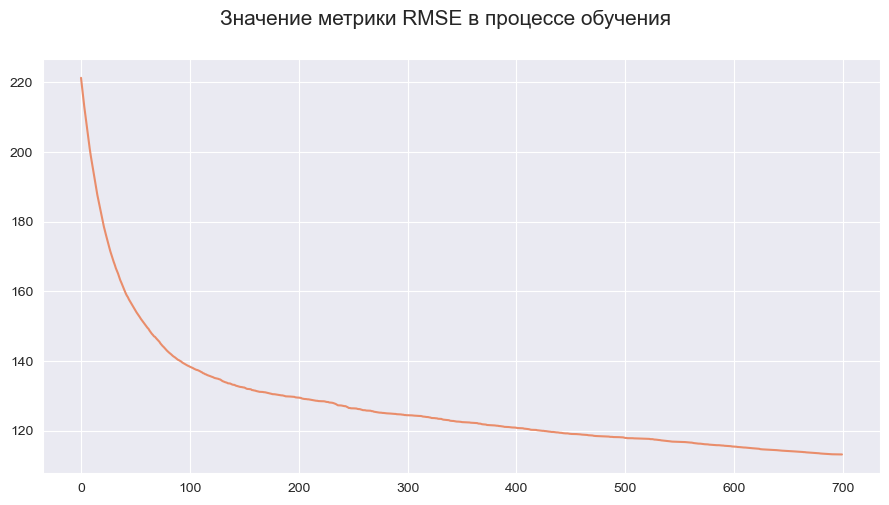

In [60]:
RMSE = model.evals_result_['learn']['RMSE']

fig, ax = plt.subplots(figsize=(9, 5))

xx = np.arange(len(RMSE))
sns.lineplot(xx, RMSE)


plt.suptitle('Значение метрики RMSE в процессе обучения', fontsize=15, y=1)
plt.tight_layout()

<span style="color:mediumblue">
Здесь представленна именно метрика RMSE, т.к. модель понижала именно ее в процессе обучения.
</span>

In [59]:
print('Итоговые параметры модели:')
for key, value in model.get_all_params().items():
    print(f'{key}: {value}')

Итоговые параметры модели:
nan_mode: Min
eval_metric: RMSE
combinations_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations: 700
sampling_frequency: PerTree
fold_permutation_block: 0
leaf_estimation_method: Newton
counter_calc_method: SkipTest
grow_policy: SymmetricTree
penalties_coefficient: 1
boosting_type: Plain
model_shrink_mode: Constant
feature_border_type: GreedyLogSum
ctr_leaf_count_limit: 18446744073709551615
bayesian_matrix_reg: 0.10000000149011612
one_hot_max_size: 2
eval_fraction: 0
force_unit_auto_pair_weights: False
l2_leaf_reg: 7
random_strength: 1
rsm: 1
boost_from_average: True
max_ctr_complexity: 4
model_size_reg: 0.5
simple_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=

### Веса признаков

In [233]:
for feature, weight in zip(model.feature_names_, model.feature_importances_):
    print(f'Принзак: {feature}, вес: {round(weight, 3)}')

Принзак: kind, вес: 6.492
Принзак: amount, вес: 30.768
Принзак: total_gb, вес: 27.67
Принзак: speed, вес: 19.685
Принзак: cas_latency, вес: 7.152
Принзак: brand, вес: 8.233


<span style="color:mediumblue">
Касательно весов фичей можно сделать следующие выводы. Фичи <i>amount</i> и <i>total_gb</i> наииболее важны для модели, но, при этом, также нету и бесполезных фичей, т.к. минимальный вес = 6.
</span>

### Метрики

In [239]:
print('Обучающая выборка:')
print(f'RMSE (Root Mean Squared Error): {round(mean_squared_error(y3_train, y3_train_pred, squared=False), 3)}')
print(f'MAE (Mean Absolute Error): {round(mean_absolute_error(y3_train, y3_train_pred), 3)}')
print(f'MAPE (Mean Absolute Percentage Error): {round(mean_absolute_percentage_error(y3_train, y3_train_pred), 3)}')
print(f'R^2 (Coefficient of determination): {round(r2_score(y3_train, y3_train_pred), 3)}')
print()
print('Тестовая выборка:')
print(f'RMSE (Root Mean Squared Error): {round(mean_squared_error(y3_test, y3_test_pred, squared=False), 3)}')
print(f'MAE (Mean Absolute Error): {round(mean_absolute_error(y3_test, y3_test_pred), 3)}')
print(f'MAPE (Mean Absolute Percentage Error): {round(mean_absolute_percentage_error(y3_test, y3_test_pred), 3)}')
print(f'R^2 (Coefficient of determination): {round(r2_score(y3_test, y3_test_pred), 3)}')

Обучающая выборка:
RMSE (Root Mean Squared Error): 116.466
MAE (Mean Absolute Error): 60.394
MAPE (Mean Absolute Percentage Error): 0.437
R^2 (Coefficient of determination): 0.73

Тестовая выборка:
RMSE (Root Mean Squared Error): 128.21
MAE (Mean Absolute Error): 64.807
MAPE (Mean Absolute Percentage Error): 0.438
R^2 (Coefficient of determination): 0.685


<span style="color:mediumblue">
Здесь я постарался вывести все возможные (имеющие при этом смысл) метрики для задачи регрессии для обучающих и тестовых данных. В целом можно сказать, что R2 = 0.7 нельзя назвать отличным результатом, но, учитывая, что потолок может быть задан в данном случае банально качеством данных, позволю себе назвать его хорошим. Значения остальных метрик тоже трудно назвать отличными, но, думаю, они удволетворительны для формата работы.
</span>

### Ошибки модели

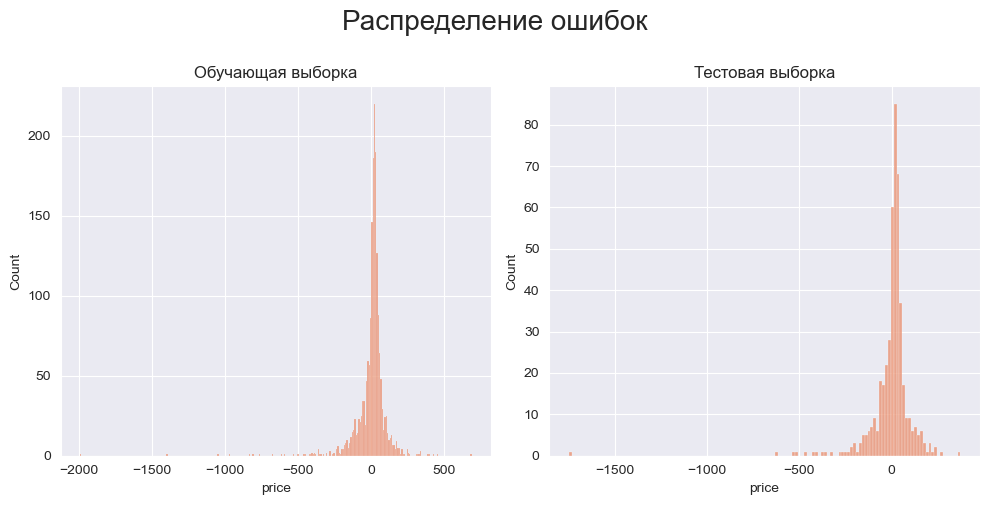

In [244]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

train_errors = y3_train_pred - y3_train
test_errors = y3_test_pred - y3_test

sns.histplot(train_errors, ax=ax[0]).set_title('Обучающая выборка')
sns.histplot(test_errors, ax=ax[1]).set_title('Тестовая выборка')

plt.suptitle('Распределение ошибок', fontsize=20, y=1)
plt.tight_layout()

<span style="color:mediumblue">
Можем видеть, что распределение ошибок похоже на нормальное c мат. ожидиданием = 0, как и должно быть.
</span>

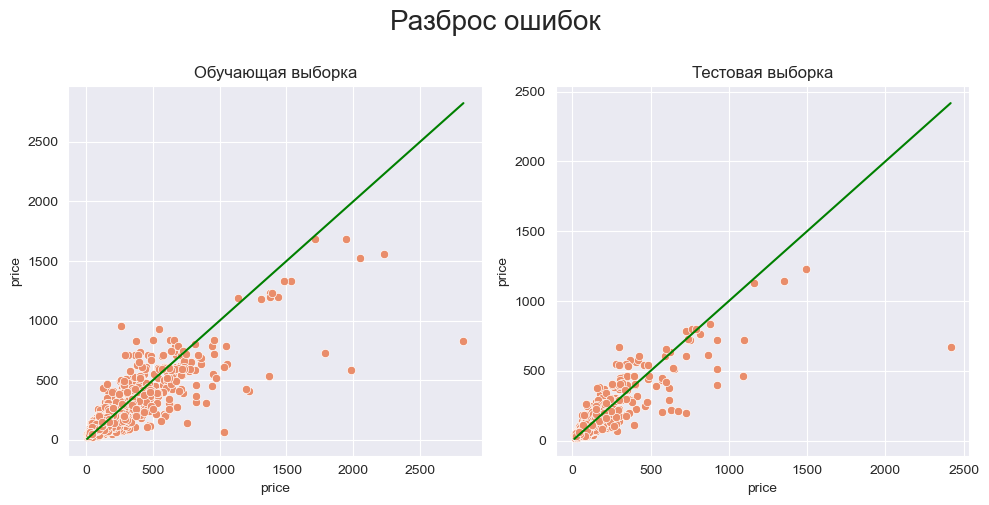

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.lineplot(y3_train, y3_train, color='g', ax=ax[0])
sns.scatterplot(y3_train ,y3_train_pred, ax=ax[0]).set_title('Обучающая выборка')

sns.lineplot(y3_test, y3_test, color='g', ax=ax[1])
sns.scatterplot(y3_test, y3_test_pred, ax=ax[1]).set_title('Тестовая выборка')

plt.suptitle('Разброс значений', fontsize=20, y=1)
plt.tight_layout()

<span style="color:mediumblue">
Разброс не идеальный, но значения, в целом, сконцентрированы вдоль построенной прямой. В целом выглядит приемлемо.
</span>

---

<span style="color:mediumblue">
Можно сказать, что с некоторой погрещностью все-таки получилось предсказывать цену оперативной памяти т.е. поставленная задача была выполнена. Также хочу поблагодарить ChatGPT за хорошие описания большиства функций, а также примеры их работы. На этом все.
</span>